<br>

# Analyzing results from evMOGA

<br>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import plotly.express as px
import plotly.graph_objects as go

import ipywidgets as widgets
from IPython.display import display

In [2]:
import evmoga as ev
from evmoga import portfolio_selection_user_functions as uf
from evmoga import utilities as evu

ev-MOGA package initialized.


## Options

In [3]:
mat_folder = "./mat_files/"

# mat_file = "evMOGApy_Eurostoxx50_2obj.mat"
# mat_file = "evMOGApy_Eurostoxx50_UB_02_3obj.mat"
mat_file = "evMOGApy_Eurostoxx50_3obj.mat"

save_results_to_xlsx = False
xlsx_folder = "./xlsx_files/"

## Import ev-MOGA results

In [11]:
mat_filename = mat_folder + mat_file

eMOGA = evu.load_eMOGA(mat_filename)

print(f"\nObjectives: {eMOGA['objectives'].tolist()}")

# Si s'han aplicat preferències a priori, però encara no s'ha tornat al espai nominal:
if 'Md' in eMOGA['param'] and 'coste_A_optimization' not in eMOGA:
    Md = eMOGA['param']['Md']
    pfront = eMOGA['coste_A'].copy()
    pfront = np.transpose(np.matmul(Md, pfront.T))        
    eMOGA['coste_A_optimization'] = eMOGA['coste_A'].copy()
    eMOGA['coste_A'] = pfront.copy()


File loaded: './mat_files/evMOGApy_Eurostoxx50_3obj.mat'

Description: 'Mean - Variance - ESG Score (3 objectives) - Eurostoxx50'

The Pareto frontier contains 2890 optimal solutions after 1000 generations (of 1000 planned)

Number of profiles: 1:

  Profile 1: 'Optimum'




Objectives: ['Mean Return', 'Variance   ', 'ESG Score  ']


## Plot evolution of Nind_A and elapsed time with generations

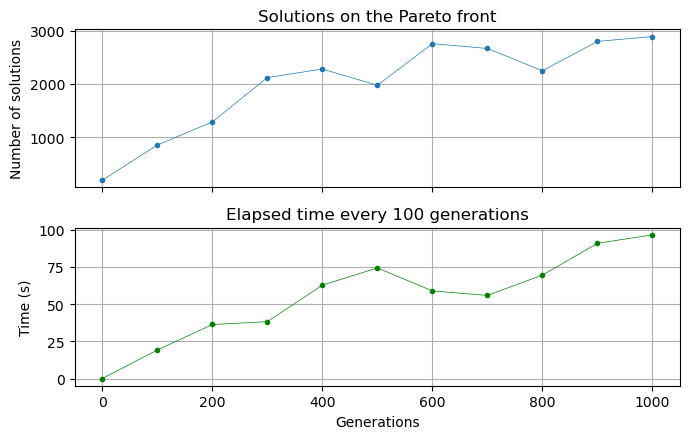

(<Figure size 700x450 with 2 Axes>,
 array([<Axes: title={'center': 'Solutions on the Pareto front'}, ylabel='Number of solutions'>,
        <Axes: title={'center': 'Elapsed time every 100 generations'}, xlabel='Generations', ylabel='Time (s)'>],
       dtype=object))

In [5]:
evu.plot_evMOGA_evolution(eMOGA)

## Adding preference profiles to eMOGA

In [6]:
if eMOGA['objfun_dim'] == 2:

    eMOGA['profiles'] = [
        { 
            'Name': 'Conservative',
            'Method': 'Preference Directions',
            'Label': 'CON',
            'Mp': np.matrix([[1.0, 0.0],
                            [1.5, 1.0]]), # v12 = 1.5
        },
        {
            'Name': 'Aggressive',
            'Method': 'Preference Directions',
            'Label': 'AGG',
            'Mp': np.matrix([[1.0, 1.5], # v21 = 1.5
                            [0.0, 1.0]]),
        }
    ]

elif eMOGA['objfun_dim'] == 3:

    eMOGA['profiles'] = [
        { 
            'Name': 'Return Driven Investor',
            'Method': 'Preference Directions',
            'Label': 'RD',
            'Mp': np.matrix([[1.0, 0.0, 1.5],
                            [0.0, 1.0, 0.0], 
                            [0.0, 0.0, 1.0]]), # v31 = 1.5
        },
        {
            'Name': 'ESG Driven Investor',
            'Method': 'Preference Directions',
            'Label': 'ESGD',
            'Mp': np.matrix([[1.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0],
                            [1.5, 0.0, 1.0]]), # v13 = 1.5
        }
    ]

eMOGA = evu.get_preference_profile_solutions(eMOGA, verbose=False)

## Plot the $\varepsilon$-Pareto frontier

In [7]:
dot_size_3D = 1.0
opt_dot_size_factor_3D = 3
dot_size_2D = 20 if eMOGA['objfun_dim'] == 2 else 2.5
opt_dot_size_factor_2D = 4 if eMOGA['objfun_dim'] == 2 else 10

eMOGA['signs'] = np.array(eMOGA['param']['signs'])
cmap = 'winter'
if 'graph options' not in eMOGA:
    eMOGA['graph options'] = dict()
eMOGA['graph options']['obj_ord_3D'] = [2, 1, 0]
eMOGA['graph options']['dot_size_3D'] = dot_size_3D
eMOGA['graph options']['opt_dot_size_factor_3D'] = opt_dot_size_factor_3D
eMOGA['graph options']['3D_view'] = {
    'azimuth': -30,
    'elevation': 20,
    'distance': 2.5,
}

evu.plot_Pareto_Front(eMOGA, cmap=cmap, plotly=True, plot_optims=True)

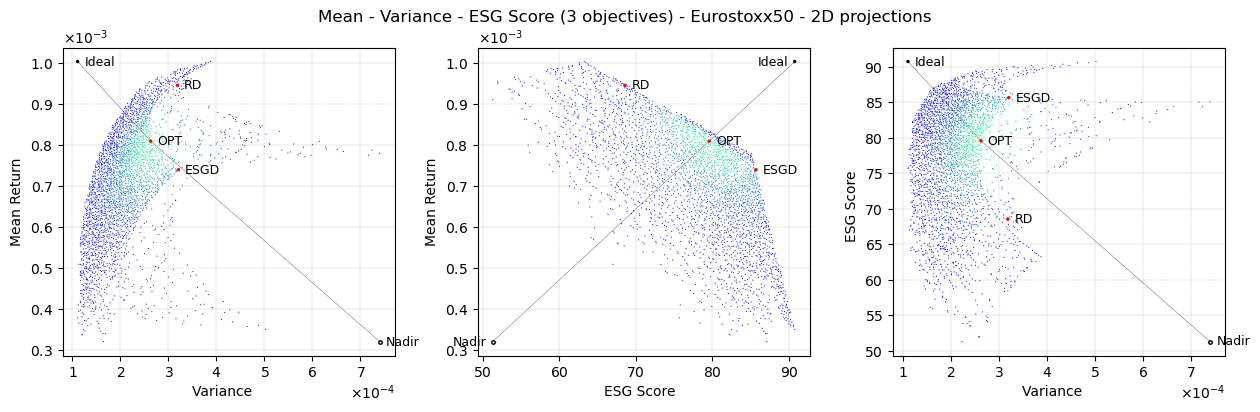

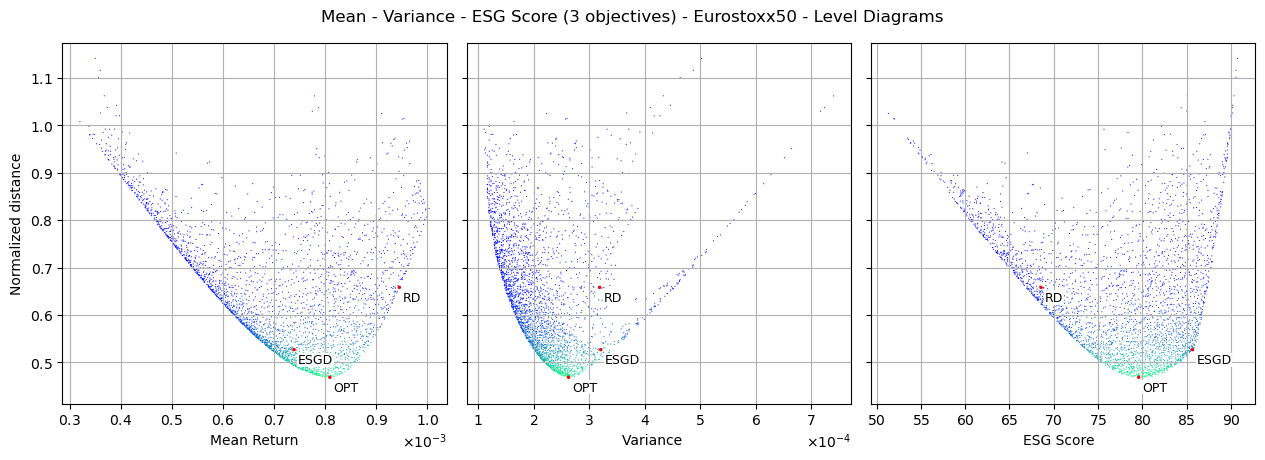

(<Figure size 1275x467.5 with 3 Axes>,
 array([<Axes: xlabel='Mean Return', ylabel='Normalized distance'>,
        <Axes: xlabel='Variance   '>, <Axes: xlabel='ESG Score  '>],
       dtype=object))

In [8]:
eMOGA['graph options']['dot_size_2D'] = dot_size_2D
eMOGA['graph options']['opt_dot_size_factor_2D'] = opt_dot_size_factor_2D

evu.plot_2D_projections(eMOGA, cmap=cmap) 
evu.plot_Level_Diagrams(eMOGA, cmap=cmap, plot_params_LD=False)

## Explore results

In [9]:
k = [i for i in range(len(eMOGA['profiles'])) if eMOGA['profiles'][i]['Name'] == 'Optimum']

if k:
    print(f"Optimum:\n")
    
    j = [i for i in range(len(eMOGA['profiles'][k[0]]['x'])) if eMOGA['profiles'][k[0]]['x'][i] > 0]
    print(f"Active variables in optimum solution: {len(j)} of {len(eMOGA['profiles'][k[0]]['x'])}\n")	
    for i in j:
        print(f"x_{i+1} = {eMOGA['profiles'][k[0]]['x'][i]:.3f}")
    
    print(f"\nz = {(eMOGA['profiles'][k[0]]['z'])}")
else:
    print("No 'Optimum' profile found")            


Optimum:

Active variables in optimum solution: 5 of 45

x_2 = 0.272
x_19 = 0.117
x_31 = 0.001
x_33 = 0.609
x_39 = 0.001

z = [8.09226830e-04 2.62974834e-04 7.95821064e+01]


## Export results to Excel

In [10]:
if save_results_to_xlsx:

    if 'signs' not in eMOGA:
        signs = eMOGA['param']['signs']
    else:
        signs = eMOGA['signs']
    df_pfront = pd.DataFrame(eMOGA['coste_A'] * signs, columns=eMOGA['objectives'])
    display(df_pfront)
    df_pset = pd.DataFrame(eMOGA['ele_A'], columns=[f'x{i+1}' for i in range(eMOGA['ele_A'].shape[1])])
    display(df_pset)
    df_returns = pd.DataFrame(eMOGA['param']['ret'], columns=[f'r_{i+1}' for i in range(eMOGA['param']['ret'].shape[1])])
    display(df_returns)

    if ".mat" in mat_filename:
        xlsx_file_name = xlsx_folder + mat_filename.split("/")[-1].replace(".mat", ".xlsx")
    else:
        xlsx_file_name = xlsx_folder + mat_filename.split("/")[-1] + ".xlsx"

    print(f"Saving results to {xlsx_file_name}...")
    with pd.ExcelWriter(xlsx_file_name) as writer:
        df_returns.to_excel(writer, sheet_name='Returns', index=False)
        df_pfront.to_excel(writer, sheet_name='Pareto front', index=False)
        df_pset.to_excel(writer, sheet_name='Pareto set', index=False)



The End